In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
import torch.nn.functional as F

class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(3304, 32)
        self.hidden_layer2 = nn.Linear(32, 32)
        self.hidden_layer3 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1652)

    def forward(self, x, y):
        # Concatenate x and y along the first dimension
        input = torch.cat([x, y], dim=0)

        layer1_out = Mish()(self.hidden_layer1(input))
        layer2_out = Mish()(self.hidden_layer2(layer1_out))
        layer3_out = Mish()(self.hidden_layer3(layer2_out))
        output = self.output_layer(layer3_out)
        return output

In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.hidden_layer1 = nn.Linear(572, 8)
#         self.hidden_layer2 = nn.Linear(8, 16)
#         self.hidden_layer3 = nn.Linear(16, 8)
#         self.output_layer = nn.Linear(8, 286)

#     def forward(self, x, y):
#         # Concatenate x and y along the first dimension
#         input = torch.cat([x, y], dim=0)

#         layer1_out = torch.tanh(self.hidden_layer1(input))
#         layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
#         layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
#         output = self.output_layer(layer3_out)
#         return output

In [ ]:
import torch.nn.init

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

In [ ]:
def f(x, y, net):
    u = net(x, y)

    # Compute the first and second derivatives
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]

    # Calculate the PDE
    pde = u_xx + u_yy
    return pde


In [ ]:
# Number of points
total_points = 1652

# Define the dimensions
x_l = 1.0
y_l = 0.4

# Number of points for each region
ip = 1440
lw_inf_points = 50
rw_inf_points = 50
tw_inf_points = 56
bw_inf_points = total_points - ip - lw_inf_points - rw_inf_points - tw_inf_points


def generate_inf_point_cloud():
    # Generate points for each region
    # interior = np.random.rand(interior_points, 2) * np.array([x_l, y_l])
    int1_points = np.array([[0.2, x] for x in np.linspace(0.0, 0.4, 360)])
    int2_points = np.array([[0.4, x] for x in np.linspace(0.0, 0.4, 360)])
    int3_points = np.array([[0.6, x] for x in np.linspace(0.0, 0.4, 360)])
    int4_points = np.array([[0.8, x] for x in np.linspace(0.0, 0.4, 360)])

    # Generate points on the left wall with x=0 and ascending y coordinates
    left_wall = np.column_stack((np.zeros(lw_inf_points), np.sort(np.random.rand(lw_inf_points) * y_l)))

    # Generate points on the right wall with x=1 and ascending y coordinates
    right_wall = np.column_stack((np.ones(rw_inf_points) * x_l, np.sort(np.random.rand(rw_inf_points) * y_l)))

    # Generate points for the top wall with y=0.4 and ascending x coordinates
    top_wall = np.column_stack((np.sort(np.random.rand(tw_inf_points)) * x_l, np.ones(tw_inf_points) * 0.4))

    # Generate points for the bottom wall with y=0 and ascending x coordinates
    bottom_wall = np.column_stack((np.sort(np.random.rand(bw_inf_points)) * x_l, np.zeros(bw_inf_points)))

    # Concatenate points without removing duplicates
    point_cloud = np.vstack((int1_points, int2_points, int3_points, int4_points, left_wall, right_wall, top_wall, bottom_wall))

    return point_cloud[:total_points]

[[0.         0.01966676]
 [0.         0.04172028]
 [0.         0.0444967 ]
 [0.         0.06262604]
 [0.         0.06684791]
 [0.         0.07538002]
 [0.         0.07912179]
 [0.         0.09059019]
 [0.         0.09872843]
 [0.         0.11227483]]


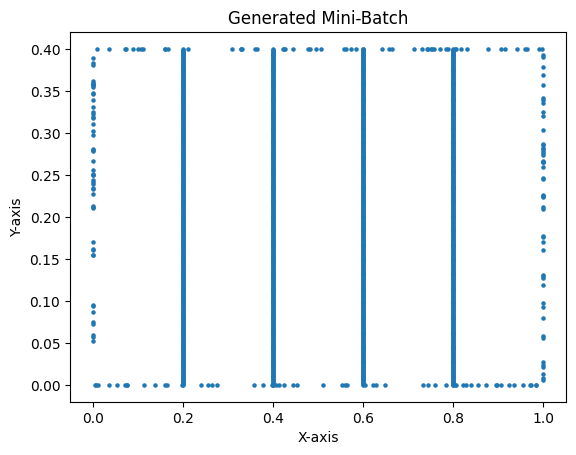

In [ ]:
# Define the dimensions
x_length = 1.0
y_length = 0.4

# Number of points for each region
interior_points = 1440
lw_points = 50
right_wall_points = 50
tw_points = 56
bw_points = total_points - interior_points - lw_points - right_wall_points - tw_points


def generate_point_cloud():
    # Generate points for each region
    interior = np.random.rand(interior_points, 2) * np.array([x_length, y_length])

    # Generate points on the left wall with x=0 and ascending y coordinates
    left_wall = np.column_stack((np.zeros(lw_points), np.sort(np.random.rand(lw_points) * y_length)))

    # Generate points on the right wall with x=1 and ascending y coordinates
    right_wall = np.column_stack((np.ones(right_wall_points) * x_length, np.sort(np.random.rand(right_wall_points) * y_length)))

    # Generate points for the top wall with y=0.4 and ascending x coordinates
    top_wall = np.column_stack((np.sort(np.random.rand(tw_points)) * x_length, np.ones(tw_points) * 0.4))

    # Generate points for the bottom wall with y=0 and ascending x coordinates
    bottom_wall = np.column_stack((np.sort(np.random.rand(bw_points)) * x_length, np.zeros(bw_points)))

    # Concatenate points without removing duplicates
    point_cloud = np.vstack((interior, left_wall, right_wall, top_wall, bottom_wall))

    return point_cloud[:total_points]



# Create a matrix of size 800x286
num_batches = 100080
points_matrix = np.zeros((num_batches, total_points, 2))

# Generate points for each mini-batch
for i in range(num_batches):
    points_matrix[i, :, :] = generate_inf_point_cloud()

print(points_matrix[7000, 1440:1450, :])

# Plot the first mini-batch
plt.scatter(points_matrix[0, :, 0], points_matrix[0, :, 1], s=5)
plt.title("Generated Mini-Batch")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


In [ ]:
def vel_x(points):
  vel = np.zeros_like(points[:,0])
  for i in range(len(points)):
    vel[i] = 4 * (points[i][1]) * (0.4 - (points[i][1]))
  return vel

def gradient(f, x):
    grad_outputs = torch.ones_like(f)  # Assuming a scalar loss, use torch.ones_like(f) if f is not scalar
    output = torch.autograd.grad(f, x, grad_outputs=grad_outputs, create_graph=True, allow_unused=True)[0]
    return output.cpu().detach().numpy()

In [ ]:
net = Net()

# Apply the initialization to your network
# net.apply(init_weights)

net = net.to(device)

mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
# Use SGD with momentum
# optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9)


Epoch: 0 BC MAE: 0.0002  | For Left Inlet: 9e-05  | For Right Outlet: 9e-05  | For Top Wall: 1e-05  | For Bottom Wall: 1e-05

LW Averaged Absolute Residue:  [1.83034477e-05 2.22058295e-05 1.20135437e-05 2.40603559e-05
 5.15329371e-05 5.42797917e-05 1.69424285e-05 6.50346470e-05
 6.16814259e-05 1.03174220e-04 5.63531614e-05 9.26630007e-05
 1.02263970e-04 8.94387182e-05 6.94556154e-05 8.10252105e-05
 1.30828479e-04 9.76651026e-05 1.04397988e-04 1.17956344e-04
 1.48135972e-04 1.19107185e-04 1.07824002e-04 1.30102732e-04
 1.43133336e-04 1.30478389e-04 9.25283161e-05 1.43604532e-04
 1.18043907e-04 1.03972284e-04 1.29669157e-04 1.24491462e-04
 1.03964051e-04 1.19078855e-04 1.50346842e-04 1.10675105e-04
 8.40750911e-05 8.46376713e-05 1.06696212e-04 7.50642457e-05
 8.84513394e-05 8.02268990e-05 8.88444537e-05 7.85400256e-05
 5.65414520e-05 5.61684489e-05 3.94841893e-05 5.20260262e-05
 1.14583962e-05 7.93553061e-06]

PDE MAE: 1e-05 Total MAE: 0.00021 Learning Rate: 0.01


Epoch: 50 BC MAE: 3e-

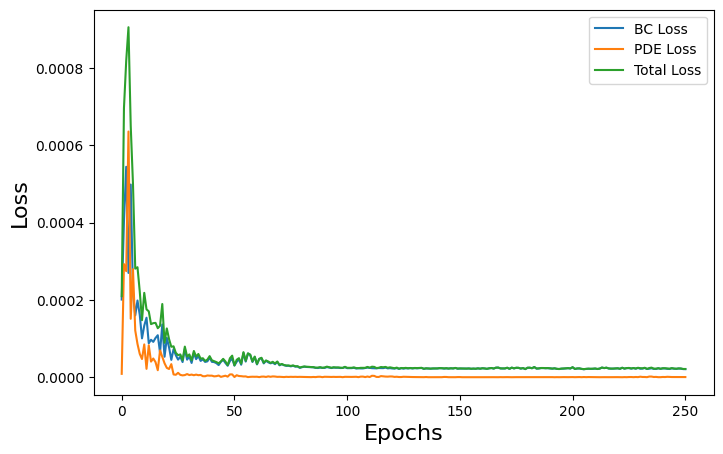

In [ ]:
import torch
from torch import nn, optim, autograd
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Assuming you have defined your network, optimizer, and other components

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.75)

iterations = 251

# Create a tensor of zeros for later use
pt_all_zeros = torch.zeros((1652,), requires_grad=True).to(device)

# Lists to store training loss values
data_losses = []
eqn_losses = []
total_losses = []

# Lists to store values for plotting
y_coordinates_list = []
abs_grad_values_list = []
residue_lw = []
average_residue_list = []  # New list to store average residue values
count = 0

# Training loop
for epoch in range(iterations):
    optimizer.zero_grad()
    data_loss = 0.0
    total_mae_lw = 0.0
    total_mae_rw = 0.0
    total_mae_tb = 0.0
    total_mae_b = 0.0
    eqn_loss = 0.0
    total_grad_phi_out_left_wall_x = 0.0
    total_residue_lw = 0.0  # Accumulator for total residue
    total_residue_rw = 0.0

    # Generate points for each mini-batch
    # for i in range(num_batches):
    #     points_matrix[i, :, :] = generate_point_cloud()

    # print(points_matrix[0:1:4])
    for i in range(80):
        batch = points_matrix[((80*count) + i), :, :]
        # Convert point_cloud batch to tensors
        pt_x_batch = Variable(torch.from_numpy(batch[:, 0]).float(), requires_grad=True).to(device)
        pt_y_batch = Variable(torch.from_numpy(batch[:, 1]).float(), requires_grad=True).to(device)

        # Pass pt_x_batch and pt_y_batch to f, not net
        f_out = f(pt_x_batch, pt_y_batch, net)  # Output of f(x, y, net) which gives R = phi_xx + phi_yy

        # Now, both tensors should have the same shape, and we can calculate the MSE
        mae_f = torch.nn.L1Loss()(f_out, torch.zeros_like(pt_x_batch))

        phi_out = net(pt_x_batch, pt_y_batch)

        # Extract left_wall_points from the batch
        left_wall_points = batch[1440:1490, :]
        right_wall_points = batch[1490:1540, :]

        # Convert left_wall_points batch to tensors
        pt_x_left_wall = Variable(torch.from_numpy(left_wall_points[:, 0]).float(), requires_grad=True).to(device)
        pt_y_left_wall = Variable(torch.from_numpy(left_wall_points[:, 1]).float(), requires_grad=True).to(device)

        # Find pt_u_bc with phi values to get the boundary condition
        vel_l = vel_x(left_wall_points)
        pt_u_batch = Variable(torch.from_numpy(vel_l).float(), requires_grad=True).to(device)

        # Calculate the gradient of phi_out_left_wall with respect to left_wall_points
        grad_phi_out_left_wall_x = autograd.grad(phi_out, pt_x_batch, torch.ones_like(phi_out), create_graph=True)[0]

        # Calculate the absolute values of grad_phi_out_left_wall_x for the last sample
        # abs_grad_values_last_sample = torch.abs(grad_phi_out_left_wall_x[180:205]).detach().cpu().numpy()

        # Calculate the residue for the left wall
        residue_lw = torch.abs(pt_u_batch - grad_phi_out_left_wall_x[1440:1490])

        # Accumulate the individual residues
        total_residue_lw += residue_lw.detach().cpu().numpy()

        # Check if gradient computation is successful
        if grad_phi_out_left_wall_x is not None:
            # Use grad_phi_out_left_wall_x in some computation
            # some_computation = torch.sum(grad_phi_out_left_wall_x[180:205])
            mae_lw = torch.nn.L1Loss()(grad_phi_out_left_wall_x[1440:1490], pt_u_batch)
        else:
            # Handle the case when gradient computation fails
            mae_lw = torch.tensor(0.0).to(device)  # or any other suitable default value

        # Accumulate the gradients
        # total_grad_phi_out_left_wall_x += torch.abs(grad_phi_out_left_wall_x[180:205]).detach().cpu().numpy()

        # Perform element-wise comparison
        # elementwise_comparison = np.isclose(vel_l, grad_phi_out_left_wall_x_numpy[180:205])

        # Print the result
        # print("=============================================================")
        # print("Boundary Condition Values: ", vel_l)
        # print("-------------------------------------------------------------")
        # print("autograd of NN output: ", grad_phi_out_left_wall_x_numpy[180:205])
        # print("-------------------------------------------------------------")
        # print("=============================================================")



        # Find pt_u_bc with phi values to get the boundary condition
        vel_r = vel_x(right_wall_points)
        pt_ur_batch = Variable(torch.from_numpy(vel_r).float(), requires_grad=True).to(device)

        # Calculate the gradient of phi_out_left_wall with respect to left_wall_points
        grad_phi_out_right_wall_x = autograd.grad(phi_out, pt_x_batch, torch.ones_like(phi_out), create_graph=True)[0]

        # Calculate the absolute values of grad_phi_out_left_wall_x for the last sample
        # abs_grad_values_last_sample = torch.abs(grad_phi_out_left_wall_x[180:205]).detach().cpu().numpy()

        # Calculate the residue for the left wall
        residue_rw = torch.abs(pt_ur_batch - grad_phi_out_right_wall_x[1490:1540])

        # Accumulate the individual residues
        total_residue_rw += residue_rw.detach().cpu().numpy()

        # Check if gradient computation is successful
        if grad_phi_out_right_wall_x is not None:
            # Use grad_phi_out_left_wall_x in some computation
            # some_computation = torch.sum(grad_phi_out_left_wall_x[180:205])
            mae_rw = torch.nn.L1Loss()(grad_phi_out_right_wall_x[1490:1540], pt_ur_batch)

        # Extract top_wall_points from the batch
        top_wall_points = batch[1540:1596, :]

        # Convert top_wall_points batch to tensors
        pt_y_top_wall = Variable(torch.from_numpy(top_wall_points[:, 1]).float(), requires_grad=True).to(device)

        # Calculate the gradient of phi_out_tb_wall with respect to top_wall_points
        grad_phi_out_top_wall_points_y = autograd.grad(phi_out, pt_y_batch, torch.ones_like(phi_out), create_graph=True)[0]

        mae_tb = torch.nn.L1Loss()(grad_phi_out_top_wall_points_y[1540:1596], torch.zeros_like(grad_phi_out_top_wall_points_y[1540:1596]))

        # Extract bottom_wall_points from the batch
        bottom_wall_points = batch[1596:, :]

        # Convert bottom_wall_points batch to tensors
        pt_y_bottom_wall = Variable(torch.from_numpy(bottom_wall_points[:, 1]).float(), requires_grad=True).to(device)

        # Calculate the gradient of phi_out_bottom_wall with respect to bottom_wall_points
        grad_phi_out_bottom_wall_points_y = autograd.grad(phi_out, pt_y_batch, torch.ones_like(phi_out), create_graph=True)[0]

        mae_b = torch.nn.L1Loss()(grad_phi_out_bottom_wall_points_y[1596:], torch.zeros_like(grad_phi_out_bottom_wall_points_y[1596:]))

        # Accumulate the individual losses
        data_loss += mae_lw + mae_tb + mae_b + mae_rw
        eqn_loss += mae_f

        total_mae_rw += mae_rw
        total_mae_lw += mae_lw
        total_mae_tb += mae_tb
        total_mae_b += mae_b

        # Append values to the lists for plotting
        # y_coordinates_list.append(left_wall_points[:, 1])
        # abs_grad_values_list.append(abs_grad_values_last_sample)

    # Calculate the average over all mini-batches
    # average_grad_phi_out_left_wall_x = total_grad_phi_out_left_wall_x / len(points_matrix)

    # Calculate the average residue over all mini-batches
    average_residue_lw = total_residue_lw / len(points_matrix)
    # average_residue_list.append(average_residue_lw)
    average_residue_rw = total_residue_rw / len(points_matrix)

    # Divide the losses by the number of batches
    data_loss /= len(points_matrix)
    eqn_loss /= len(points_matrix)
    total_mae_lw /= len(points_matrix)
    total_mae_rw /= len(points_matrix)
    total_mae_tb /= len(points_matrix)
    total_mae_b /= len(points_matrix)

    # Calculate the total loss
    total_loss = data_loss + eqn_loss

    # Perform backward pass
    total_loss.backward()
    optimizer.step()

    # Update the learning rate
    scheduler.step()

    # Store training losses for later plotting
    data_losses.append(data_loss.item())
    eqn_losses.append(eqn_loss.item())
    total_losses.append(total_loss.item())

    count += 1

    # Print training loss every 50 epochs
    if epoch % 50 == 0:
        with torch.autograd.no_grad():
            print("")
            print("=============================================================")
            # print("Epoch:", epoch, "BC Loss:", round(data_loss.item(), 5))
            print("Epoch:", epoch, "BC MAE:", round(data_loss.item(), 5), " | For Left Inlet:", round(total_mae_lw.item(), 5), " | For Right Outlet:", round(total_mae_rw.item(), 5), " | For Top Wall:", round(total_mae_tb.item(), 5), " | For Bottom Wall:", round(total_mae_b.item(), 5))
            print("")
            # print("-------------------------------------------------------------")
            # print("Average Grad Values for Left Inlet:")
            # print(average_grad_phi_out_left_wall_x)
            # print("-------------------------------------------------------------")
            # print("MAE(left Inlet): ", mae_lw.detach().cpu().numpy())
            # print("-------------------------------------------------------------")
            # print("-------------------------------------------------------------")
            print("LW Averaged Absolute Residue: ", average_residue_lw)
            # print("-------------------------------------------------------------")
            print("")
            print("PDE MAE:", round(eqn_loss.item(), 5), "Total MAE:", round(total_loss.item(), 5), "Learning Rate:", round(optimizer.param_groups[0]['lr'], 5))
            print("=============================================================")
            print("")

            y_coordinates = left_wall_points[:, 1]
            bar_width = 0.2
            x_positions = np.linspace(0, len(y_coordinates) - 1, len(y_coordinates))

            # ax.bar(x_positions, average_residue_lw, width=bar_width, label='Abs Residue Values Averaged over the Mini-Batch')

            # ax.set_xticks(x_positions)
            # ax.set_xticklabels([f'{coord:.2f}' for coord in y_coordinates], rotation=45, ha='right')
            # ax.set_xlabel('Y Coordinates', fontsize=16)
            # ax.set_ylabel('Abs Avg Residue Values', fontsize=16)
            # ax.set_title('Epoch: {}'.format(epoch))
            # ax.legend()  # Add legend here

            # plt.tight_layout()
            # plt.show()

            # # Plot the values for the last sample in the mini-batch as a bar plot
            # fig, ax = plt.subplots(figsize=(8, 5))

            # y_coordinates = left_wall_points[:, 1]

            # ax.bar(x_positions, abs_grad_values_last_sample, width=bar_width, label='Abs Grad Values for Last Sample in Mini-Batch')

            # ax.set_xticks(x_positions)
            # ax.set_xticklabels([f'{coord:.2f}' for coord in y_coordinates], rotation=45, ha='right')
            # ax.set_xlabel('Y Coordinates', fontsize=16)
            # ax.set_ylabel('Abs Grad Values', fontsize=16)
            # ax.set_title('Epoch: {}'.format(epoch))
            # ax.legend()  # Add legend here

            # plt.tight_layout()
            # plt.show()

# Plot the losses
fig = plt.figure(figsize=(8, 5))
ax = plt.axes()

ax.plot(range(0, iterations), data_losses, label='BC Loss')
ax.plot(range(0, iterations), eqn_losses, label='PDE Loss')
ax.plot(range(0, iterations), total_losses, label='Total Loss')

ax.set_xlabel('Epochs', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)

plt.legend()
plt.show()

In [ ]:
print(count)

251


In [ ]:
# Set the model to evaluation mode
net.eval()

Net(
  (hidden_layer1): Linear(in_features=3304, out_features=32, bias=True)
  (hidden_layer2): Linear(in_features=32, out_features=32, bias=True)
  (hidden_layer3): Linear(in_features=32, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=1652, bias=True)
)

[[0.2        0.        ]
 [0.2        0.00111421]
 [0.2        0.00222841]
 [0.2        0.00334262]
 [0.2        0.00445682]
 [0.2        0.00557103]
 [0.2        0.00668524]
 [0.2        0.00779944]
 [0.2        0.00891365]
 [0.2        0.01002786]]


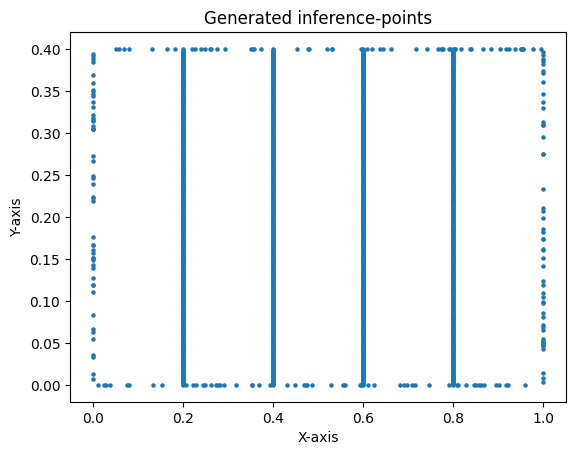

In [ ]:

validation = generate_inf_point_cloud()

print(validation[:10,:])

# Plot the first mini-batch
plt.scatter(validation[:, 0], validation[:, 1], s=5)
plt.title("Generated inference-points")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


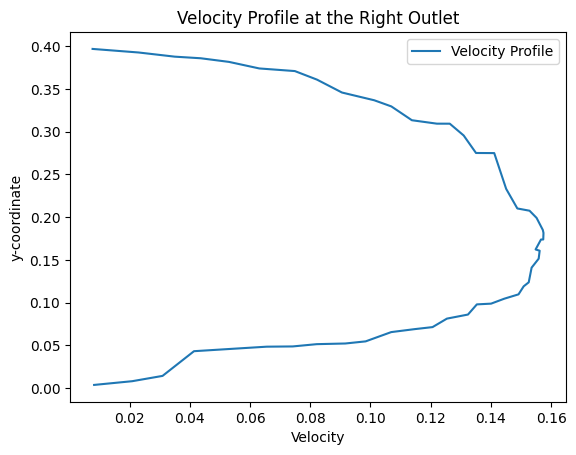

In [ ]:
# Convert right_wall_points batch to tensors with gradient tracking
pt_x_rw = Variable(torch.from_numpy(validation[:, 0]).float(), requires_grad=True).to(device)
pt_y_rw = Variable(torch.from_numpy(validation[:, 1]).float(), requires_grad=True).to(device)

# Forward pass through the trained model
vel_rw = net(pt_x_rw, pt_y_rw)

# Calculate the gradient of the neural network output with respect to x
# vel_right_wall_x_gradient = torch.autograd.grad(vel_right_wall.sum(), pt_x_right_wall, create_graph=True)[0]
vel_rw_x_gradient = autograd.grad(vel_rw, pt_x_rw, torch.ones_like(vel_rw), create_graph=True)[0]
print()
# Plot the gradient profile at the right wall
plt.plot(vel_rw_x_gradient[1490:1540].detach().cpu().numpy(), pt_y_rw[1490:1540].detach().cpu().numpy(), label='Velocity Profile')
plt.ylabel('y-coordinate')
plt.xlabel('Velocity')
plt.title('Velocity Profile at the Right Outlet')
plt.legend()


plt.show()


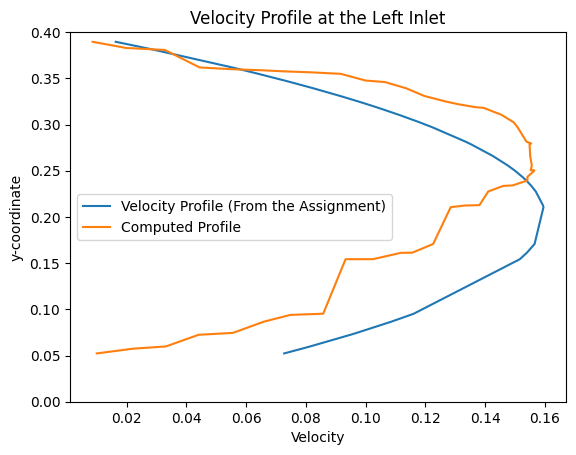

In [ ]:
# # Generate points along the left wall
# left1_points = np.array([[0.2, x] for x in np.linspace(0.0, 0.4, 143)])
# left2_points = np.array([[0.4, x] for x in np.linspace(0.0, 0.4, 143)])
# left3_points = np.array([[0.6, x] for x in np.linspace(0.0, 0.4, 143)])
# left4_points = np.array([[0.6, x] for x in np.linspace(0.0, 0.4, 143)])
# # pt_x_batch = Variable(torch.from_numpy(points_matrix[0, :, :]).float(), requires_grad=True).to(device)

# left_points = np.concatenate((left1_points, left2_points, left3_points, left4_points), axis=0)

# print(left_points.shape)

# Convert left_wall_points batch to tensors
pt_x_left_wall = Variable(torch.from_numpy(points_matrix[0, :, 0]).float(), requires_grad=True).to(device)
pt_y_left_wall = Variable(torch.from_numpy(points_matrix[0, :, 1]).float(), requires_grad=True).to(device)

vel_l = vel_x(points_matrix[0, 1440:1490, :])

# Forward pass through the trained model for the left wall
vel_left_wall = net(pt_x_left_wall, pt_y_left_wall)

# Calculate the gradient of the neural network output with respect to x for the left wall
# vel_left_wall_x_gradient = torch.autograd.grad(vel_left_wall.sum(), pt_x_left_wall, create_graph=True, retain_graph=True)[0]
vel_left_wall_x_gradient = autograd.grad(vel_left_wall, pt_x_left_wall, torch.ones_like(vel_left_wall), create_graph=True)[0]

# Plot both vel_l and vel_left_wall_x_gradient[180:205] on the same graph
plt.plot(vel_l, pt_y_left_wall[1440:1490].detach().cpu().numpy(), label='Velocity Profile (From the Assignment)')
plt.plot(vel_left_wall_x_gradient[1440:1490].detach().cpu().numpy(), pt_y_left_wall[1440:1490].detach().cpu().numpy(), label='Computed Profile')
# plt.plot(vel_left_wall_x_gradient[143:286].detach().cpu().numpy(), pt_y_left_wall[143:286].detach().cpu().numpy(), label='At x=0.4')
# plt.plot(vel_left_wall_x_gradient[286:429].detach().cpu().numpy(), pt_y_left_wall[286:429].detach().cpu().numpy(), label='At x=0.6')
# plt.plot(vel_left_wall_x_gradient[429:].detach().cpu().numpy(), pt_y_left_wall[429:].detach().cpu().numpy(), label='At x = 0.8')

# Display legends and show the plot
plt.ylabel('y-coordinate')
plt.xlabel('Velocity')
plt.title('Velocity Profile at the Left Inlet')
plt.legend()

# Set the y-axis range from 0 to 0.4
plt.ylim(0, 0.4)

# Show the plot
plt.show()



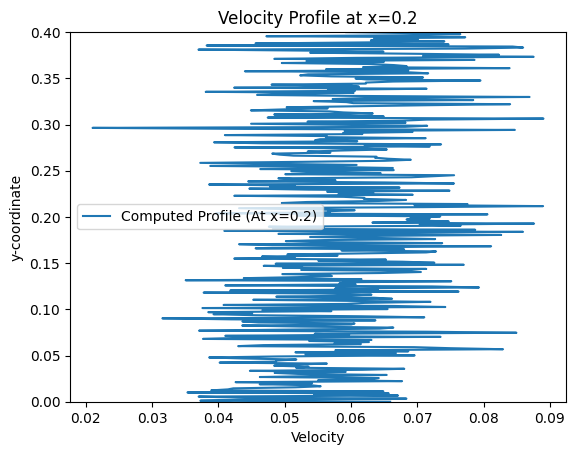

In [ ]:
# Generate points along the left wall
# left_wall_points = np.array([[0.0, x] for x in np.linspace(0.0, 0.4, 286)])
# pt_x_batch = Variable(torch.from_numpy(points_matrix[0, :, :]).float(), requires_grad=True).to(device)

# Convert left_wall_points batch to tensors
pt_x_left_wall1 = Variable(torch.from_numpy(validation[:, 0]).float(), requires_grad=True).to(device)
pt_y_left_wall1 = Variable(torch.from_numpy(validation[:, 1]).float(), requires_grad=True).to(device)

vel_l1 = vel_x(validation)

# Forward pass through the trained model for the left wall
vel_left_wall1 = net(pt_x_left_wall1, pt_y_left_wall1)

# Calculate the gradient of the neural network output with respect to x for the left wall
# vel_left_wall_x_gradient = torch.autograd.grad(vel_left_wall.sum(), pt_x_left_wall, create_graph=True, retain_graph=True)[0]
vel_left_wall_x_gradient1 = autograd.grad(vel_left_wall1, pt_x_left_wall1, torch.ones_like(vel_left_wall1), create_graph=True)[0]

# Plot both vel_l and vel_left_wall_x_gradient[180:205] on the same graph
# plt.plot(vel_l1[360:410], pt_y_left_wall1[360:410].detach().cpu().numpy(), label='Velocity Profile (From the Assignment)')
plt.plot(vel_left_wall_x_gradient1[:360].detach().cpu().numpy(), pt_y_left_wall1[:360].detach().cpu().numpy(), label='Computed Profile (At x=0.2)')

# Display legends and show the plot
plt.ylabel('y-coordinate')
plt.xlabel('Velocity')
plt.title('Velocity Profile at x=0.2')
plt.legend()

# Set the y-axis range from 0 to 0.4
plt.ylim(0, 0.4)

# Show the plot
plt.show()



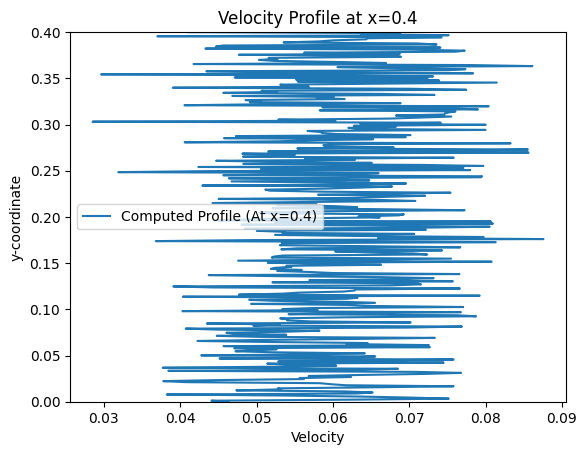

In [ ]:
# Generate points along the left wall
# left_wall_points = np.array([[0.0, x] for x in np.linspace(0.0, 0.4, 286)])
# pt_x_batch = Variable(torch.from_numpy(points_matrix[0, :, :]).float(), requires_grad=True).to(device)

# Convert left_wall_points batch to tensors
pt_x_left_wall1 = Variable(torch.from_numpy(validation[:, 0]).float(), requires_grad=True).to(device)
pt_y_left_wall1 = Variable(torch.from_numpy(validation[:, 1]).float(), requires_grad=True).to(device)

vel_l1 = vel_x(validation)

# Forward pass through the trained model for the left wall
vel_left_wall1 = net(pt_x_left_wall1, pt_y_left_wall1)

# Calculate the gradient of the neural network output with respect to x for the left wall
# vel_left_wall_x_gradient = torch.autograd.grad(vel_left_wall.sum(), pt_x_left_wall, create_graph=True, retain_graph=True)[0]
vel_left_wall_x_gradient1 = autograd.grad(vel_left_wall1, pt_x_left_wall1, torch.ones_like(vel_left_wall1), create_graph=True)[0]

# Plot both vel_l and vel_left_wall_x_gradient[180:205] on the same graph
# plt.plot(vel_l1[360:410], pt_y_left_wall1[360:410].detach().cpu().numpy(), label='Velocity Profile (From the Assignment)')
plt.plot(vel_left_wall_x_gradient1[360:720].detach().cpu().numpy(), pt_y_left_wall1[360:720].detach().cpu().numpy(), label='Computed Profile (At x=0.4)')

# Display legends and show the plot
plt.ylabel('y-coordinate')
plt.xlabel('Velocity')
plt.title('Velocity Profile at x=0.4')
plt.legend()

# Set the y-axis range from 0 to 0.4
plt.ylim(0, 0.4)

# Show the plot
plt.show()



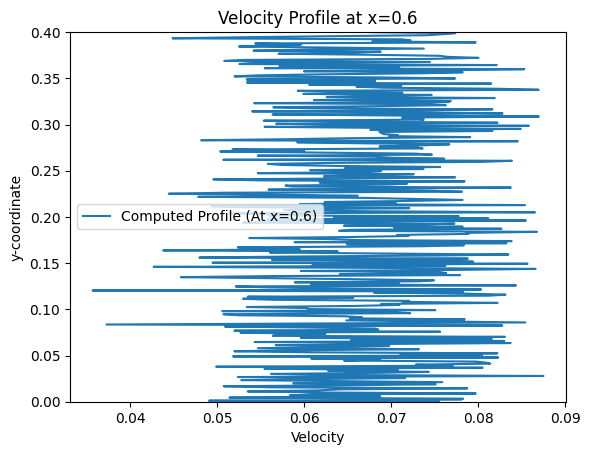

In [ ]:
# Generate points along the left wall
# left_wall_points = np.array([[0.0, x] for x in np.linspace(0.0, 0.4, 286)])
# pt_x_batch = Variable(torch.from_numpy(points_matrix[0, :, :]).float(), requires_grad=True).to(device)

# Convert left_wall_points batch to tensors
pt_x_left_wall1 = Variable(torch.from_numpy(validation[:, 0]).float(), requires_grad=True).to(device)
pt_y_left_wall1 = Variable(torch.from_numpy(validation[:, 1]).float(), requires_grad=True).to(device)

vel_l1 = vel_x(validation)

# Forward pass through the trained model for the left wall
vel_left_wall1 = net(pt_x_left_wall1, pt_y_left_wall1)

# Calculate the gradient of the neural network output with respect to x for the left wall
# vel_left_wall_x_gradient = torch.autograd.grad(vel_left_wall.sum(), pt_x_left_wall, create_graph=True, retain_graph=True)[0]
vel_left_wall_x_gradient1 = autograd.grad(vel_left_wall1, pt_x_left_wall1, torch.ones_like(vel_left_wall1), create_graph=True)[0]

# Plot both vel_l and vel_left_wall_x_gradient[180:205] on the same graph
# plt.plot(vel_l1[360:410], pt_y_left_wall1[360:410].detach().cpu().numpy(), label='Velocity Profile (From the Assignment)')
plt.plot(vel_left_wall_x_gradient1[720:1080].detach().cpu().numpy(), pt_y_left_wall1[720:1080].detach().cpu().numpy(), label='Computed Profile (At x=0.6)')

# Display legends and show the plot
plt.ylabel('y-coordinate')
plt.xlabel('Velocity')
plt.title('Velocity Profile at x=0.6')
plt.legend()

# Set the y-axis range from 0 to 0.4
plt.ylim(0, 0.4)

# Show the plot
plt.show()



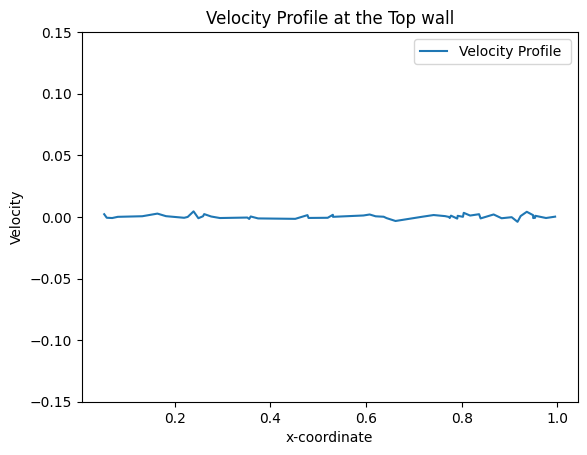

In [ ]:
# Convert right_wall_points batch to tensors with gradient tracking
pt_x_v_top_wall = Variable(torch.from_numpy(validation[:, 0]).float(), requires_grad=True).to(device)
pt_y_v_top_wall = Variable(torch.from_numpy(validation[:, 1]).float(), requires_grad=True).to(device)

# Forward pass through the trained model
vel_v_top_wall = net(pt_x_v_top_wall, pt_y_v_top_wall)

# Calculate the gradient of the neural network output with respect to x
# vel_right_wall_x_gradient = torch.autograd.grad(vel_right_wall.sum(), pt_y_right_wall, create_graph=True)[0]
vel_v_top_wall_x_gradient = autograd.grad(vel_v_top_wall, pt_y_v_top_wall, torch.ones_like(vel_v_top_wall), create_graph=True)[0]

# Plot the gradient profile at the right wall
plt.plot(pt_x_v_top_wall[1540:1596].detach().cpu().numpy(), vel_v_top_wall_x_gradient[1540:1596].detach().cpu().numpy(), label='Velocity Profile ')
plt.xlabel('x-coordinate')
plt.ylabel('Velocity')
plt.title('Velocity Profile at the Top wall')
plt.legend()

# Set the y-axis range from 0 to 0.4
plt.ylim(-0.15, 0.15)

plt.show()
